In [219]:
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA , TruncatedSVD
from sklearn.datasets import load_iris 
from sklearn.preprocessing import StandardScaler 
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [221]:
#Import Data
df = pd.read_csv('Customer_data.csv')

## Data Preprocessing

In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               200 non-null    int64  
 1   Gender                   200 non-null    object 
 2   Age                      200 non-null    int64  
 3   Income (k$)              200 non-null    int64  
 4   How Much They Spend ($)  200 non-null    int64  
 5   Salary (k$)              200 non-null    float64
 6   Spend to income ratio    200 non-null    float64
 7   Alpha                    200 non-null    int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 12.6+ KB


In [226]:
# Check for missing values
df.isnull().sum()

CustomerID                 0
Gender                     0
Age                        0
Income (k$)                0
How Much They Spend ($)    0
Salary (k$)                0
Spend to income ratio      0
Alpha                      0
dtype: int64

In [228]:
# Drop Alpha based on metadata
df = df.drop(columns=['Alpha'])
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (200, 7)


,CustomerID,Gender,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio
0,1,Male,19,15,39,1.054960,0.036968
1,2,Male,21,15,81,0.676210,0.119785
2,3,Female,20,16,6,0.562232,0.010672
3,4,Female,23,16,77,1.284359,0.059952
4,5,Female,31,17,40,0.806683,0.049586


In [230]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df.head()

,CustomerID,Gender,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio
0,1,0,19,15,39,1.054960,0.036968
1,2,0,21,15,81,0.676210,0.119785
2,3,1,20,16,6,0.562232,0.010672
3,4,1,23,16,77,1.284359,0.059952
4,5,1,31,17,40,0.806683,0.049586


In [232]:
# Replace with your numeric feature columns:
features = ['Age', 'Gender', 'Income (k$)', 'How Much They Spend ($)', 'Salary (k$)', 'Spend to income ratio']

In [234]:
features

['Age',
 'Gender',
 'Income (k$)',
 'How Much They Spend ($)',
 'Salary (k$)',
 'Spend to income ratio']

In [236]:
#StandardScaler
X = df[features].to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Based on Kmeans Silhouette, k=10 shows the best results

In [239]:
#Kmeans Silhouette
# Loop through k values
for n_cluster in range(2,11):
    kmeans = KMeans(n_clusters=n_cluster, n_init='auto', random_state=42)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    sil_coeff = silhouette_score(X_scaled, labels, metric='euclidean')
    print(f"For n_clusters={n_cluster}, The Silhouette Coefficient is {sil_coeff:.4f}")
warnings.filterwarnings('ignore') # Hides all warnings

For n_clusters=2, The Silhouette Coefficient is 0.2239
For n_clusters=3, The Silhouette Coefficient is 0.2500
For n_clusters=4, The Silhouette Coefficient is 0.2747
For n_clusters=5, The Silhouette Coefficient is 0.2711
For n_clusters=6, The Silhouette Coefficient is 0.2916
For n_clusters=7, The Silhouette Coefficient is 0.3042
For n_clusters=8, The Silhouette Coefficient is 0.3013
For n_clusters=9, The Silhouette Coefficient is 0.3051
For n_clusters=10, The Silhouette Coefficient is 0.3100


In [241]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
warnings.filterwarnings('ignore') # Hides all warnings

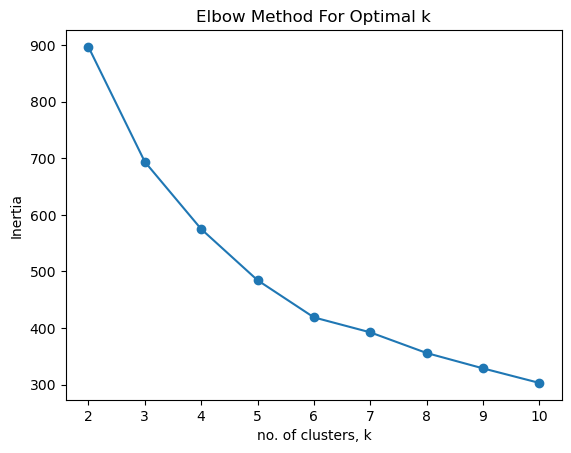

In [243]:
plt.plot(k_range, inertia, '-o')
plt.xlabel('no. of clusters, k')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.title('Elbow Method For Optimal k')
plt.show()

## PRINCIPAL COMPONENT ANALYSIS
### Reduce to 2 dimension

In [246]:
# PCA for 2D scatter
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
centers_pca = pca.transform(kmeans.cluster_centers_)
centers_orig = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers_orig, columns=features)

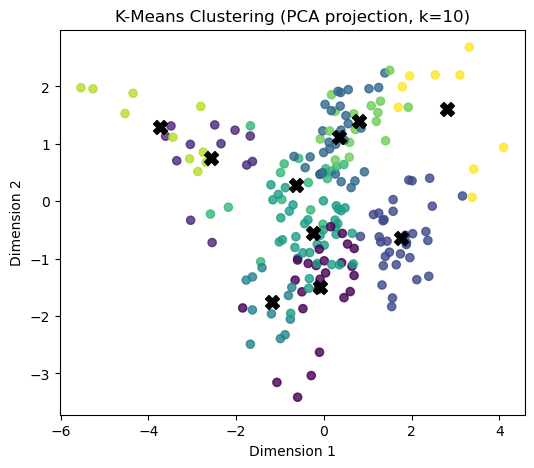

In [248]:
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=35, alpha=0.8, cmap='viridis')
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=100, marker='X')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title(f'K-Means Clustering (PCA projection, k=10)')
plt.show()

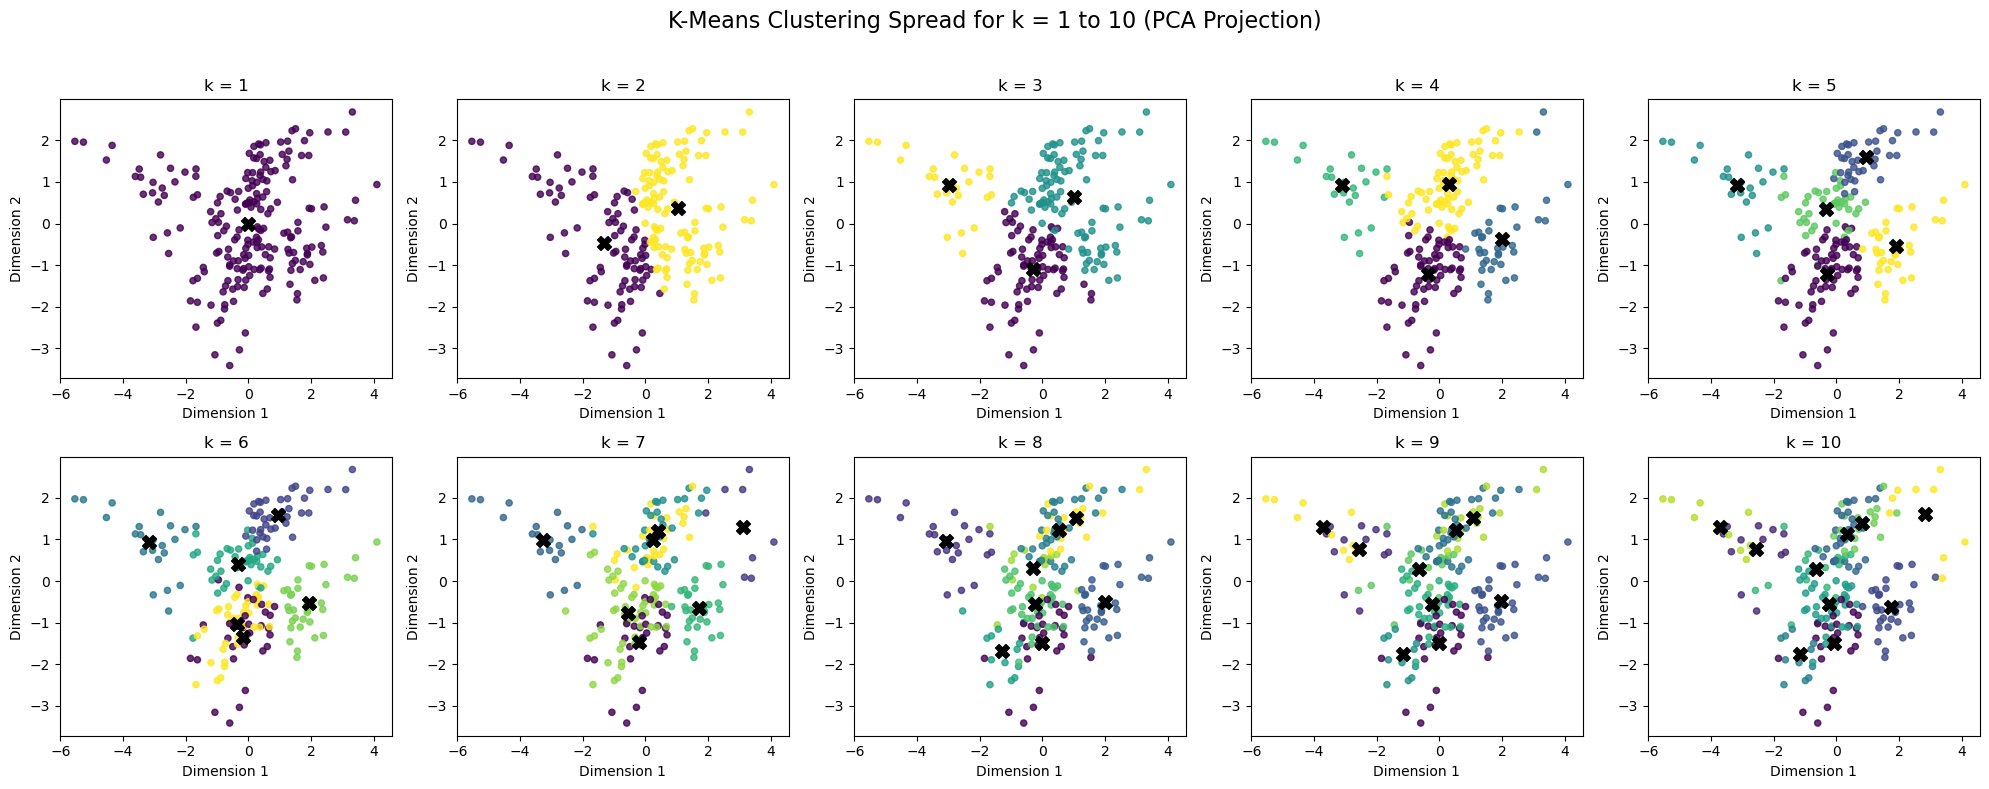

In [250]:
## Plot different clusters

#Loop k=1 to k=10
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns
axes = axes.flatten()

for i, k in enumerate(range(1, 11)):
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = km.fit_predict(X_scaled)
    centers_pca = pca.transform(km.cluster_centers_)
    
    ax = axes[i]
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=20, cmap='viridis', alpha=0.8)
    ax.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=100, marker='X')
    ax.set_title(f'k = {k}')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

plt.suptitle("K-Means Clustering Spread for k = 1 to 10 (PCA Projection)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [252]:
#based on the observation best_k = 4 is the best
best_k = 4

kmeans = KMeans(n_clusters=best_k, n_init='auto', random_state=42)
labels = kmeans.fit_predict(X_scaled)
df['cluster'] = labels

#Cluster sizes
sizes = df['cluster'].value_counts().sort_index()
sizes

cluster
0    65
1    37
2    23
3    75
Name: count, dtype: int64

In [254]:
# PCA for 2D scatter
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
centers_pca = pca.transform(kmeans.cluster_centers_)
centers_orig = scaler.inverse_transform(kmeans.cluster_centers_)


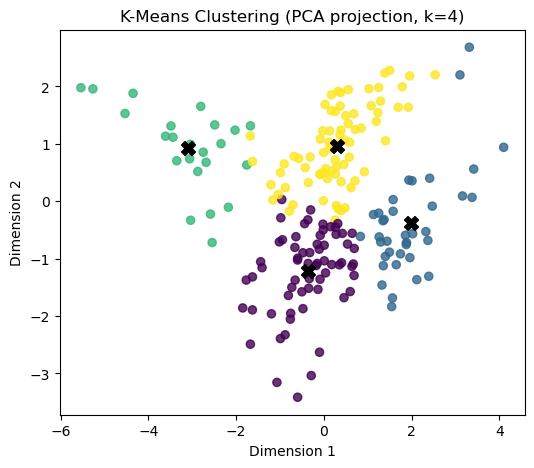

In [256]:
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=35, alpha=0.8, cmap='viridis')
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=100, marker='X')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title(f'K-Means Clustering (PCA projection, k={best_k})')
plt.show()

In [258]:
# 3d) Melted df for combined boxplots
df_melt = df.melt(id_vars='cluster', value_vars=features, var_name='Feature', value_name='Value')

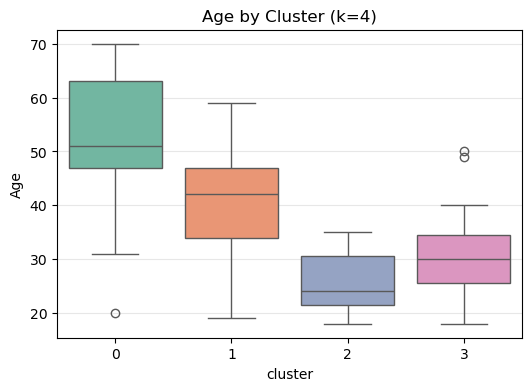

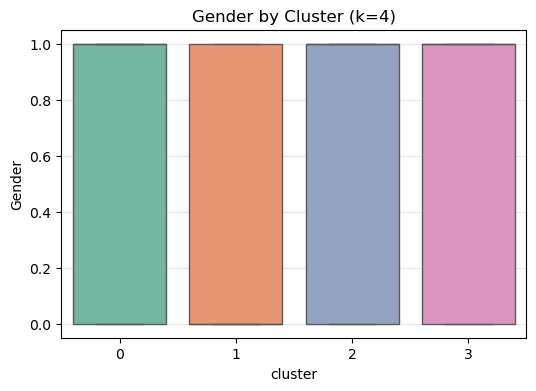

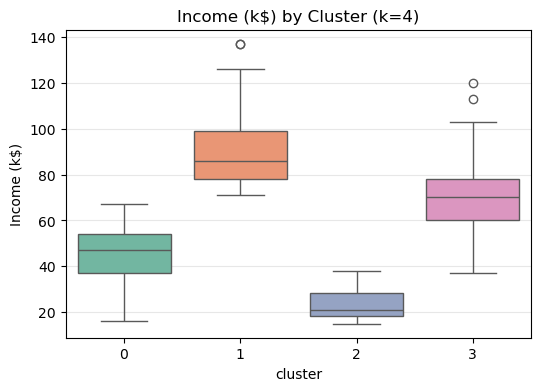

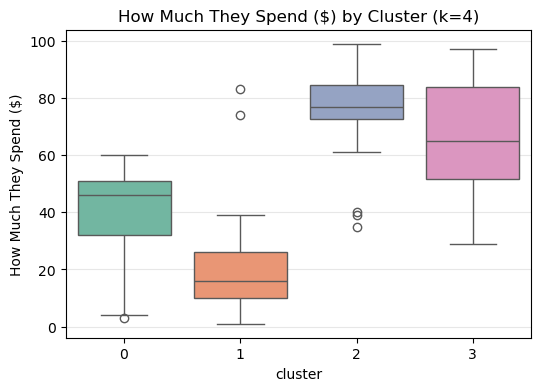

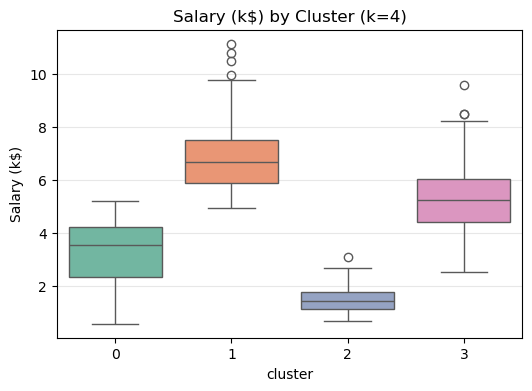

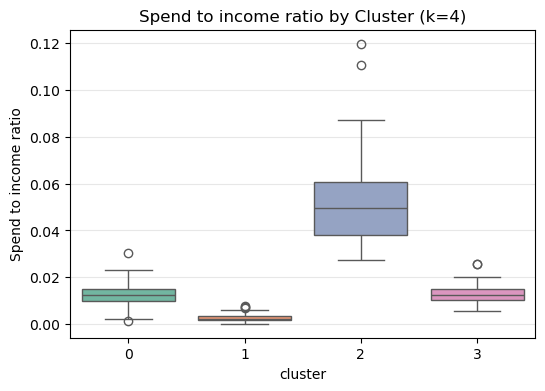

In [260]:
5) Boxplots per feature
for feat in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x='cluster', y=feat, palette="Set2")
    plt.title(f"{feat} by Cluster (k={best_k})")
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()


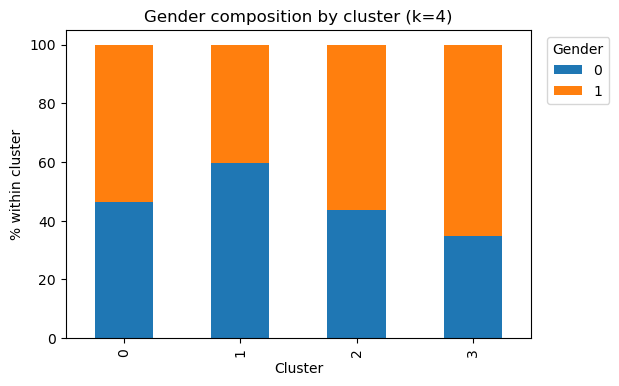

In [262]:
# stacked % by cluster
pct = pd.crosstab(df['cluster'], df['Gender'], normalize='index').mul(100)
ax = pct.plot(kind='bar', stacked=True, figsize=(6,4))
ax.set_ylabel('% within cluster')
ax.set_xlabel('Cluster')
ax.legend(title='Gender', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.title(f'Gender composition by cluster (k={best_k})')
plt.show()


# Hierarchical Clustering

In [265]:
#AgglomerativeClustering

for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k) 
    labels_agg = agg.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels_agg, metric='euclidean')
    print(f"For n_clusters={k}, silhouette = {sil:.4f}")


For n_clusters=2, silhouette = 0.3405
For n_clusters=3, silhouette = 0.2315
For n_clusters=4, silhouette = 0.2704
For n_clusters=5, silhouette = 0.2495
For n_clusters=6, silhouette = 0.2643
For n_clusters=7, silhouette = 0.2920
For n_clusters=8, silhouette = 0.3198
For n_clusters=9, silhouette = 0.3247
For n_clusters=10, silhouette = 0.3268


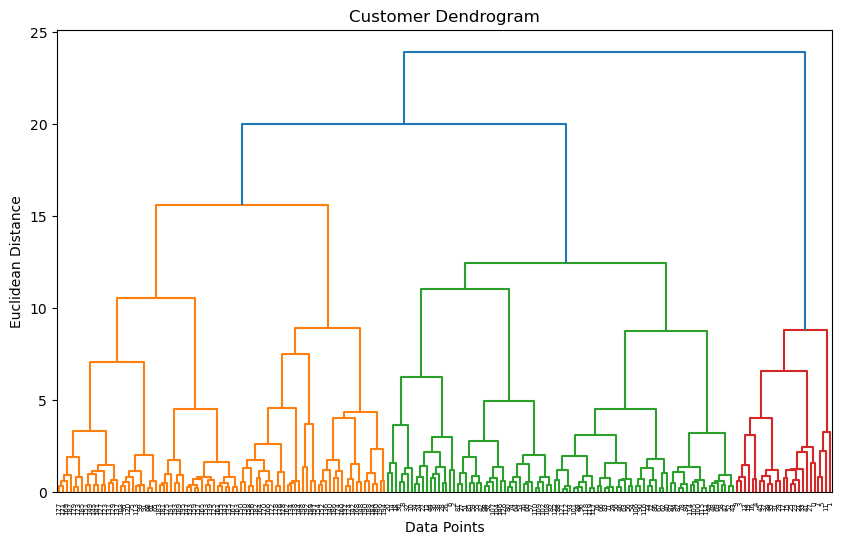

In [267]:
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)


plt.title('Customer Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')

# Remove grid lines
plt.grid(False)

plt.show()


In [269]:
profile = (df.groupby('cluster')[['Age','Salary (k$)','How Much They Spend ($)','Spend to income ratio']].agg(['count','mean','median']))
display(profile)


Age                   Salary (k$)                      \
        count       mean median       count      mean    median   
cluster                                                           
0          65  52.492308   51.0          65  3.245094  3.549155   
1          37  41.108108   42.0          37  7.044177  6.655788   
2          23  25.956522   24.0          23  1.542935  1.408615   
3          75  29.866667   30.0          75  5.340685  5.216974   

        How Much They Spend ($)                   Spend to income ratio  \
                          count       mean median                 count   
cluster                                                                   
0                            65  39.907692   46.0                    65   
1                            37  20.594595   16.0                    37   
2                            23  74.782609   77.0                    23   
3                            75  66.186667   65.0                    75   

                             
             mean    median  
cluster                      
0        0.012740  0.012635  
1        0.002833  0.002117  
2        0.054803  0.049586  
3        0.012931  0.012416